## Hierarchical classification
idea from YOLO9000

code from https://github.com/AtsushiHashimoto/keras_hierarchical_prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


scripts/per_group_func.py

In [2]:
import warnings
import keras.backend as K
class PerGroupFunc():
    def __init__(self, is_sequential=False):
        self.funcs = []
        self.scopes = [] # (start,end) tuples
        self.weights = []
        self.is_sequential=is_sequential
        
    def register(self, func, scope, weight=1.0):
        self.funcs.append(func)
        self.scopes.append(scope)
        self.weights.append(weight)
        
    @staticmethod
    def gen_slice(scope, len_shape):
        return [slice(None)]*(len_shape-1) + [slice(*scope)]
        
        
    def call(self, y_true, y_pred):
        if len(self.funcs)==0:
            warnings.warn("No loss functions are set.")
            return 0
        len_shape = len(y_true.shape)
        # value and validity(typically, 0.f or 1.f)        
        val_validity = [f(y_true[self.gen_slice(sc,len_shape)], y_pred[self.gen_slice(sc,len_shape)]) for (f,sc) in zip(self.funcs, self.scopes)]            
                     
        is_first = True
        for vs, w in zip(val_validity, self.weights):
            if is_first:
                is_first = False
                val = vs[0]*w
                _sum = vs[1]
                continue
            val += vs[0]*w
            _sum += vs[1]
        return val / _sum

Using TensorFlow backend.


In [3]:
#from scripts.category_tree import CategoryTree

import multiprocessing
from keras.activations import softmax
import keras.backend as K
from keras import metrics
#from .per_group_func import PerGroupFunc
import numpy as np


# original algorithm/code is from this URL
# https://github.com/pjreddie/darknet/blob/1e729804f61c8627eb257fba8b83f74e04945db7/src/tree.c
class CategoryTree:
    def __init__(self, tree, leaf=None, n_jobs=multiprocessing.cpu_count()):
        self.tree = tree
        self.leaf = leaf
        self.n_jobs=n_jobs
        
        # constract parent/child links and group segments
        self.labels, self.parents, self.is_leaf = self.serialize(tree,leaf=leaf)
        self.nlabels = len(self.labels)
        # alias
        self.nclasses = self.nlabels
        print ("nclasses=", self.nclasses)
        self.ncats = self.nlabels
        
        self.group_segments, group_nums, _ = self.rlencode(self.parents)
        # append a large index to access by zip(group_segments[:-1],group_segments[1:])
        self.group_segments = np.append(self.group_segments, [self.nlabels])

        self.child_group = [None] * self.nlabels
        for idx in range(self.nlabels)[::-1]:
            p_idx = self.parents[idx]
            if p_idx <0:
                continue
            gidx = np.where([idx in range(*r) for r in self.group_iter()])[0][0]
            self.child_group[p_idx]=gidx
            
        self.encoder = {l:idx for idx, l in enumerate(self.labels)}

        self.depth = self.get_depth(tree, leaf=leaf)
        
    @staticmethod
    def get_depth(tree, leaf=None):
        depths = [CategoryTree.get_depth(v) for k,v in tree.items() if v is not None and v != leaf]
        if len(depths)==0:
            return 1
        else:
            return max(depths)+1
        
    def get_sorting_code(self, categorical_label, key=None):
        if key is None:
            key = [i for i in range(self.n_labels)]
        idx = np.where(categorical_label==1)[0]
        code =  [key[i] for i in idx] +  [-1] * (self.depth - len(idx))
        assert(len(code)==self.depth)
        return code

    
    @staticmethod
    def set_label(cat, encoder, lut4conv, parents):
        if isinstance(cat, list):
            if len(cat)==0:
                return np.zeros((len(parents),))
            if len(cat)==1:
                # treat cat as a single value
                cat = cat[0]
            else:
                # apply set_label for each element.
                return np.array([CategoryTree.set_label(c, encoder, lut4conv, parents) for c in cat])
        
        # if cat is not a list
        n_hot_vector = np.zeros((len(parents),))
        if isinstance(cat,str):
            cat = encoder[cat]
        if lut4conv is not None:
            cat = lut4conv[cat]
        n_hot_vector[cat] = 1
        parent = parents[cat]
        while parent >=0:
            n_hot_vector[parent] = 1
            parent = parents[parent]
        return n_hot_vector
            
    @staticmethod
    def set_label_wrap(args):
        return CategoryTree.set_label(*args)

    
    def to_hierarchical_categorical(self, ys, lut4conv=None):
        with multiprocessing.Pool(self.n_jobs) as p:
            n_hot_vectors = p.map(CategoryTree.set_label_wrap, [(y, self.encoder, lut4conv, self.parents) for y in ys])
        return np.array(n_hot_vectors)
                
        
    def generate_func(self, primitive_func, func_name, per_group_func=None):
        def _func(y_true,y_pred):
            weights = K.sum(y_true,axis=-1,keepdims=False)
            val = primitive_func(y_true,y_pred)
            #sum_weights = K.sum(weights,axis=-1,keepdims=False)
            #return K.sum(weights * primitive_func(y_true,y_pred), axis=-1,keepdims=False)/sum_weights
            return weights * val, weights
        if per_group_func is None:
            per_group_func = PerGroupFunc()
        else:
            per_group_func = per_group_func
        for (s,e) in self.group_iter():
            per_group_func.register(_func,(s,e))
        
        func_name = per_group_func.call
        return func_name
    
    def generate_loss_func(self, primitive_func=K.categorical_crossentropy, func_name='hierarchical_categorical_loss', **kwargs):
        return self.generate_func(primitive_func, func_name,**kwargs)
    
    def generate_acc_func(self, primitive_func=metrics.categorical_accuracy, func_name='hierarchical_categorical_acc', **kwargs):
        return self.generate_func(primitive_func, func_name,**kwargs)
    
    def hierarchical_softmax(self, x, axis=-1):
        bufs = [softmax(x[:,s:e],axis) for (s,e) in self.group_iter()]
        return K.concatenate(bufs, axis=-1)
    
    def group_iter(self):
        return zip(self.group_segments[:-1], self.group_segments[1:])

    def print_debug(self):
        print("labels:    ",self.labels)
        print("parents: ",self.parents)
        print("is_leaf:   ",self.is_leaf)
        print("group_segments: ", self.group_segments)
        print("child_group: ", self.child_group)
        print("encoder: ",self.encoder)
    def decode(self, cat):
        return self.labels[cat]
    def encode(self, label):
        return self.encoder[label]
    
    def get_hierarchy_probability(self, predictions, cat, prob=1.0):
        assert(len(predictions)==self.nlabels)
        parent = self.parents[cat]
        prob = predictions[cat] * prob 
        if parent<0:
            return prob
        return self.get_hierarchy_probability(predictions, parent, prob)
        
    def hierarchy_predictions(self, _predictions, only_leaves=False):
        assert(len(_predictions)==self.nlabels)
        predictions = _predictions.copy()
        
        for idx, p in enumerate(predictions):
            parent = self.parents[idx]
            if parent<0:
                continue
            p_parent = predictions[parent]
            predictions[idx] = p * p_parent
            
        if only_leaves:
            predictions[not self.is_leaf] = 0.0
        return predictions
        
    
    # trace the maximum prediction node in brothers at each depth level.
    def hierarchy_top_prediction(self, predictions, thresh):
        assert(len(predictions)==self.nlabels)
        prob = 1.0
        gidx = 0
        max_idx = -1
        while gidx != None:
            g_range = self.group_segments[gidx:gidx+2]
            g_max_idx = np.argmax(predictions[g_range[0]:g_range[1]]) +g_range[0]
            
            if(prob*predictions[g_max_idx] < thresh):
                # no children satisfies prob > thresh
                if max_idx == -1:
                    return None, 0.0
                return max_idx, prob
            
            prob *= predictions[g_max_idx]
            max_idx = g_max_idx
            gidx = self.child_group[max_idx]
        
        return max_idx, prob
            
        
    @staticmethod
    def rlencode(x, dropna=False):
        """
        Run length encoding.
        Based on http://stackoverflow.com/a/32681075, which is based on the rle 
        function from R.
        Parameters
        ----------
        x : 1D array_like
            Input array to encode
        dropna: bool, optional
            Drop all runs of NaNs.
        Returns
        -------
        start positions, run lengths, run values
        """
        where = np.flatnonzero
        x = np.asarray(x)
        n = len(x)
        if n == 0:
            return (np.array([], dtype=int), 
                    np.array([], dtype=int), 
                    np.array([], dtype=x.dtype))

        starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
        lengths = np.diff(np.r_[starts, n])
        values = x[starts]

        if dropna:
            mask = ~np.isnan(values)
            starts, lengths, values = starts[mask], lengths[mask], values[mask]

        return starts, lengths, values
    
    
    @staticmethod
    def serialize_one_depth(tree, parent_label,parent_idx,leaf):
            labels = list(tree.keys())
            if parent_idx >=0 and len(labels)==1:
                # this key has no brother.
                # add parent as the non-'labels[0]' class) 
                labels.append(parent_label)
            labels.sort()
            n_labels = len(labels)
            parents = [parent_idx] * n_labels
            is_leaf = [key not in tree.keys() or tree[key]==None for key in labels]
            subtrees = [None] * n_labels
            for idx, key in enumerate(labels):
                if is_leaf[idx]:
                    continue
                subtrees[idx] = tree[key]
            
            return labels, parents, is_leaf, subtrees
        
    @staticmethod
    def serialize(tree, parent_label=None, leaf=None):
        # return self.labels, self.parents, self.is_leaf    

        arg_stacks = [(tree, parent_label,-1)]

        labels = []
        parents = []
        is_leaf = []
        while len(arg_stacks)>0:
            l=[]
            p=[]
            i=[] 
            subtrees = []
            for args in arg_stacks:
                print ("---",  args)
                _l,_p,_i,_s = CategoryTree.serialize_one_depth(*args,leaf)
                l += _l
                p += _p
                i += _i
                subtrees += _s
            arg_stacks = []
            for idx, child in enumerate(l):
                if i[idx]:
                    continue
                arg_stacks.append((subtrees[idx], child, len(labels)+idx))
            labels += l
            parents += p
            is_leaf += i
        return np.array(labels),np.array(parents),np.array(is_leaf)
    
    def prune_rare_cat(self, frequency, pruning_threshold=0.00, background_cats =['END']):  
        if pruning_threshold < 1.0:
            thresh = int(pruning_threshold * sum(frequency.values()) / len(frequeny) )
        else:
            thresh = pruning_threshold
        freq_hierarchical = np.zeros(len(self.parents))    
        for l,f in frequency.items():
            p=self.encoder[l]
            while(p>=0):
                freq_hierarchical[p]+=f
                p = self.parents[p]

        def delete_rare(subtree):
            # 
            if not isinstance(subtree,dict):
                return subtree
            
            del_list = []
            for key in subtree.keys():
                f = freq_hierarchical[self.encoder[key]]
                if f <= thresh and key not in background_cats:                    
                    del_list.append(key)
                    continue
                if self.is_leaf[self.encoder[key]]:
                    continue
                subtree[key] = delete_rare(subtree[key])
            for key in del_list:
                del subtree[key]

            # subtreeが1つの要素しかなく，かつ，その要素がさらに木構造を持つならば， 
            # その階層は飛ばす
            if len(subtree.keys())==1:
                key,val = next(iter(subtree.items()))
                if not self.is_leaf[self.encoder[key]]:
                    subtree = delete_rare(val)
            if isinstance(subtree,dict):
                if len(subtree)==0:
                    return None
            return subtree
        
        tr = delete_rare(self.tree)
        return CategoryTree(tr, self.leaf,n_jobs=self.n_jobs)
    
        def cats(self):
            return self.encoder.keys()
                
        
        

In [4]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy

#from scipy.misc import toimage scipy.misc.toimage is removed since v1.2
from PIL import Image
from keras.datasets import cifar10
import keras.utils as Kutils

In [5]:
import tensorflow as tf
from keras.backend import set_session,tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list="0"))
config.gpu_options.per_process_gpu_memory_fraction = 0.49
set_session(tf.Session(config=config))

result_dir = './'
#from scripts.category_tree import CategoryTree

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
nclasses = 10

LEAF = None

# hierarchy for cifar10
category_tree={
      "transport": 
         {  "airplane":LEAF, 
             "automobile":{ # note that automobile has only one child, a counter class is automatically filled lator.
                "truck":LEAF}, 
             "ship":LEAF}
      ,
      "animal": {
           "bird":LEAF, 
           "frog":LEAF, 
           "mammal": {
               "deer": LEAF,
               "dog": LEAF,
               "cat": LEAF,
               "horse": LEAF
           }
       } 
}

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [7]:
# debug code (tree construction and prediction)

cat_tree = CategoryTree(category_tree)
cat_tree.print_debug()

predictions_dummy = np.array([0.1,0.9]+[0.3,0.3,0.4]+[0.05,0.9,0.05]+[0.1,0.0,0.85,0.05]+[0.2,0.8])

# functions to evaluate/analyze results
top_cat, prob = cat_tree.hierarchy_top_prediction(predictions_dummy, 0.1)
print(cat_tree.decode(top_cat),": %f"%prob)
print([cat_tree.get_hierarchy_probability(predictions_dummy,cat) for cat in range(cat_tree.nlabels)])
print(cat_tree.hierarchy_predictions(predictions_dummy))


--- ({'transport': {'airplane': None, 'automobile': {'truck': None}, 'ship': None}, 'animal': {'bird': None, 'frog': None, 'mammal': {'deer': None, 'dog': None, 'cat': None, 'horse': None}}}, None, -1)
--- ({'bird': None, 'frog': None, 'mammal': {'deer': None, 'dog': None, 'cat': None, 'horse': None}}, 'animal', 0)
--- ({'airplane': None, 'automobile': {'truck': None}, 'ship': None}, 'transport', 1)
--- ({'deer': None, 'dog': None, 'cat': None, 'horse': None}, 'mammal', 4)
--- ({'truck': None}, 'automobile', 6)
nclasses= 14
labels:     ['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile'
 'ship' 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']
parents:  [-1 -1  0  0  0  1  1  1  4  4  4  4  6  6]
is_leaf:    [False False  True  True False  True False  True  True  True  True  True
  True  True]
group_segments:  [ 0  2  5  8 12 14]
child_group:  [1, 2, None, None, 3, None, 4, None, None, None, None, None, None, None]
encoder:  {'animal': 0, 'transport': 1, 'bird': 2, 'fro

In [8]:
# debug code (n hot vector conversion)

# original_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# tree labels(=cat_tree.labels:     ['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile' 'ship' 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']
n_hot_vectors = cat_tree.to_hierarchical_categorical(np.array(['bird','cat','automobile','transport','frog','airplane','deer']))
print(n_hot_vectors)

# by label
# tree labels(=cat_tree.labels):     ['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile' 'ship' 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']
n_hot_vectors2 = cat_tree.to_hierarchical_categorical(np.array([[2],[8],[12],[1],[3],[5],[9]]))
print(np.all(n_hot_vectors==n_hot_vectors2))

[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
True


In [9]:
def plot_cifar10(X_train, y_train, result_dir):
    pos = 1
    for targetClass in range(nclasses):
        targetIdx = []
        for i in range(len(y_train)):
            if y_train[i][0] == targetClass:
                targetIdx.append(i)

        np.random.shuffle(targetIdx)
        for idx in targetIdx[:10]:
            #img = toimage(X_train[idx])
            img = Image.fromarray(X_train[idx])
            plt.subplot(10, 10, pos)
            plt.imshow(img)
            plt.axis('off')
            pos += 1

    plt.show()

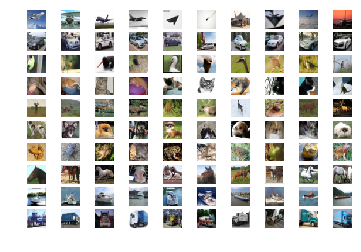

In [10]:
img_rows, img_cols = 32, 32
img_channels = 3

(X_train, _y_train), (X_test, _y_test) = cifar10.load_data()

plot_cifar10(X_train, y_train, result_dir)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [11]:
# Convert the original label encoding to hierarchical label encoding
def make_lut(orig_labels,hier_labels):
    lut = [0]*len(orig_labels)
    hier_labels_rev = hier_labels[::-1]
    N = len(hier_labels)
    for oi, ol in enumerate(orig_labels):
        lut[oi] = N - hier_labels_rev.index(ol)  -1
    return np.array(lut)
original_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
lut = make_lut(original_labels, list(cat_tree.labels))
print(cat_tree.labels)

y_train = cat_tree.to_hierarchical_categorical(lut[_y_train])
y_test = cat_tree.to_hierarchical_categorical(lut[_y_test])

['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile'
 'ship' 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(cat_tree.nclasses)) # CAUTION: here, ncalsses is not 10!!
#model.add(Activation('softmax',name='predictions'))
model.add(Activation(cat_tree.hierarchical_softmax,name='predictions')) # CAUTION: you must use hierarchical_softmax!

model.compile(loss=cat_tree.generate_loss_func(), # CAUTION: you must use a loss function generated by cat tree.
              optimizer='adam',
              metrics=[cat_tree.generate_acc_func()])

In [13]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
__________

In [14]:
from keras.preprocessing.image import ImageDataGenerator
epochs=30
data_augmentation = True
batch_size=128
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

    
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using real-time data augmentation.
Epoch 1/30
390/390 [==============================] - 26s 67ms/step - loss: 0.7053 - call: 0.6868 - val_loss: 0.5599 - val_call: 0.7694
Epoch 2/30
390/390 [==============================] - 24s 60ms/step - loss: 0.5684 - call: 0.7552 - val_loss: 0.5146 - val_call: 0.7832
Epoch 3/30
390/390 [==============================] - 24s 61ms/step - loss: 0.5006 - call: 0.7895 - val_loss: 0.5251 - val_call: 0.7890
Epoch 4/30
390/390 [==============================] - 24s 61ms/step - loss: 0.4556 - call: 0.8124 - val_loss: 0.3651 - val_call: 0.8536
Epoch 5/30
390/390 [==============================] - 24s 61ms/step - loss: 0.4268 - call: 0.8266 - val_loss: 0.5763 - val_call: 0.7735
Epoch 6/30
390/390 [==============================] - 24s 61ms/step - loss: 0.4065 - call: 0.8361 - val_loss: 0.3915 - val_call: 0.8438
Epoch 7/30
390/390 [==============================] - 24s 61ms/step - loss: 0.3878 - call: 0.8446 - val_loss: 0.6054 - val_call: 0.7725
Epoch 8/30
39

In [15]:

model_file_basename = "%shierarchical_no_data_augumentation"%(result_dir)
model.save_weights(model_file_basename+".hdf5")
print("save to %s"%model_file_basename+".hdf5")

save to ./hierarchical_no_data_augumentation.hdf5


dict_keys(['val_loss', 'val_call', 'loss', 'call'])


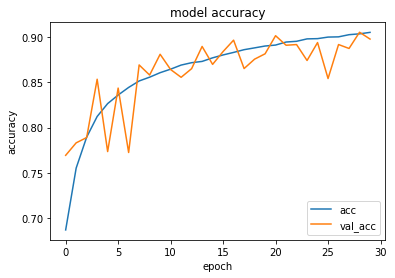

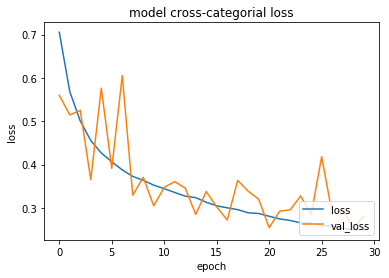

In [16]:
def plot_history(history):
    print(history.history.keys())

    plt.plot(history.history['call'])
    plt.plot(history.history['val_call'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.savefig(model_file_basename+".acc.png")
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model cross-categorial loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.savefig(model_file_basename+".loss.png")
    plt.show()

print(history)
plot_history(history)

# Caution: The accuracy looks great, but this is due to accurate estimation at anscestor categories.


In [17]:
y_pred = model.predict(X_test)
def get_label(n_hot_vector):
    return cat_tree.decode(np.where(n_hot_vector==1)[0][-1])
    
def print_labels(_y_pred,thresholds, y_true):
    labels = []
    y_true = get_label(y_true)
    for th in thresholds:
        cat, prob = cat_tree.hierarchy_top_prediction(_y_pred, th)
        if cat==None:          
            continue
        label = cat_tree.decode(cat)
        labels.append("%s(%f)"%(label,prob))
    if len(labels)==0:
        # failed to predict label at the top level categories
        print("[%s]: "%y_true)
        return
    label = labels[0][0]
    if len(labels)==len(thresholds) and np.all([l[0]==label for l in labels]):
        return
    labels = [l for l,l2 in zip(labels,labels[1:]+[None]) if l!=l2]
    print("[%s]: "%y_true, "\t".join(labels))

step = 0.1
thresholds = np.arange(0.50,1.0+step,step)
for i in range(1000):
    print_labels(y_pred[i],thresholds, y_test[i])

[cat]:  dog(0.570213)	mammal(0.941288)
[ship]:  ship(0.992774)	transport(1.000000)
[ship]:  ship(0.996515)	transport(1.000000)
[airplane]:  ship(0.595531)	transport(0.999981)
[frog]:  frog(0.998573)
[frog]:  frog(0.999440)
[automobile]:  automobile(0.899880)	automobile(0.999517)
[frog]:  frog(0.944859)
[cat]:  cat(0.753607)	mammal(0.857023)	animal(0.996599)
[automobile]:  automobile(0.998850)
[airplane]:  airplane(0.982087)
[truck]:  truck(0.998979)	transport(1.000000)
[dog]:  mammal(0.505007)	animal(0.992820)
[horse]:  horse(0.992903)
[truck]:  truck(0.997718)	transport(1.000000)
[ship]:  ship(0.999703)
[dog]:  dog(0.983728)
[horse]:  truck(0.562997)	automobile(0.864174)	transport(0.921655)
[ship]:  ship(0.999953)	transport(1.000000)
[frog]:  frog(0.999996)
[horse]:  horse(0.991717)
[airplane]:  airplane(0.999888)
[deer]:  deer(0.834733)
[truck]:  truck(0.999950)	automobile(1.000000)
[dog]:  deer(0.954613)
[bird]:  animal(0.673295)
[deer]:  mammal(0.591009)	animal(0.876350)
[airplane]

In [18]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [19]:
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
print ("----------------")
print (tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6747239979253573701
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12022153940810545386
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7005639744662153141
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8365150044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14128011835018972821
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
----------------
True
True


In [20]:
import tensorflow as tf
print (tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

1.13.1
Default GPU Device: /device:GPU:0
